In [38]:
!pip install kaggle
!pip install opendatasets

In [39]:
import opendatasets as od
import pandas
import pandas as pd
import fastai
from fastai.tabular.all import *
import torch


token = {"username":"nkkoraki","key":"1e6184fc9d3bbfea40161ce222deadee"}
od.download("https://www.kaggle.com/competitions/spaceship-titanic")



Skipping, found downloaded files in "./spaceship-titanic" (use force=True to force download)


In [47]:
test_data = pd.read_csv("/content/spaceship-titanic/test.csv")
train_data = pd.read_csv("/content/spaceship-titanic/train.csv")
train_data.drop("PassengerId",axis=1, inplace = True)
train_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [48]:
c = []
n = []
stay = ["Transported"]
for i in train_data.columns:
        if i not in stay and (train_data[i].dtype) in ['object']:
            c.append(i)

for i in train_data.columns:
    if i not in stay and i not in c:
      n.append(i)
print(train_data[c].info())
print(train_data[n].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   HomePlanet   8492 non-null   object
 1   CryoSleep    8476 non-null   object
 2   Cabin        8494 non-null   object
 3   Destination  8511 non-null   object
 4   VIP          8490 non-null   object
 5   Name         8493 non-null   object
dtypes: object(6)
memory usage: 407.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8514 non-null   float64
 1   RoomService   8512 non-null   float64
 2   FoodCourt     8510 non-null   float64
 3   ShoppingMall  8485 non-null   float64
 4   Spa           8510 non-null   float64
 5   VRDeck        8505 non-null   float64
dtypes: float64(6)
memory usage: 407.6 KB
None


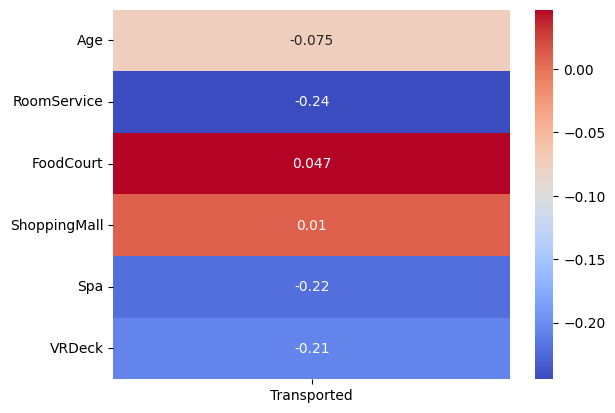

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
correlations = train_data[n + ["Transported"]].corr()["Transported"].drop("Transported")
correlation_df = correlations.to_frame()
sns.heatmap(correlation_df,
            cmap = "coolwarm",
            annot = True,
            cbar = True)
plt.show()

In [50]:
train_data.drop(columns = ["Name", "RoomService", "Spa", "VRDeck"])

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,FoodCourt,ShoppingMall,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,9.0,25.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3576.0,0.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,1283.0,371.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,70.0,151.0,True
...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,6819.0,0.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,1872.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,1049.0,0.0,False


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Transported   8693 non-null   bool   
dtypes: bool(1), float64(3), object(5)
memory usage: 551.9+ KB


In [51]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_data))

to = TabularPandas(train_data, procs=[Normalize,Categorify, FillMissing],
                   cat_names = c,
                   cont_names = n,
                   y_names='Transported',
                   splits=splits)

to.xs.head()
dls = to.dataloaders(bs=64)
dls.show_batch()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Mars,False,F/1871/P,TRAPPIST-1e,False,Pil Ancy,False,False,False,False,False,False,28.000000,1.789000e+03,15.999979,3.000007,9.999986,1.000002,False
1,Earth,False,F/817/P,TRAPPIST-1e,False,Elanie Sullones,False,False,False,False,False,False,28.000000,6.530000e+02,-0.000011,-0.000007,0.000011,20.000003,False
2,Mars,True,F/1005/P,55 Cancri e,False,Cird Fisty,False,False,False,False,False,False,2.999999,4.901885e-07,-0.000011,-0.000007,0.000011,0.000011,True
3,Earth,False,F/133/S,TRAPPIST-1e,False,Branda Potthews,False,False,False,False,False,False,23.000000,1.390000e+02,-0.000011,1.000003,151.999993,353.999998,True
4,Europa,False,B/116/P,TRAPPIST-1e,False,Diphah Dervalt,False,False,False,False,False,False,45.000000,4.901885e-07,-0.000011,-0.000007,0.000011,0.000011,False
5,Europa,True,B/161/S,55 Cancri e,False,Wezno Foraud,True,False,False,False,False,False,27.000000,4.901885e-07,-0.000011,-0.000007,0.000011,0.000011,True
6,Earth,False,F/1567/S,TRAPPIST-1e,False,Hary Puckenton,False,False,False,False,False,False,18.000000,4.901885e-07,-0.000011,662.000000,30.000004,0.000011,True
7,Earth,True,G/272/P,TRAPPIST-1e,False,Camina Dillestron,False,False,False,False,False,False,2.999999,4.901885e-07,-0.000011,-0.000007,0.000011,0.000011,True
8,Earth,False,E/139/P,TRAPPIST-1e,False,Vandy Whitez,False,False,False,False,False,False,20.000000,4.901885e-07,409.000000,994.000006,215.000003,0.000011,False
9,Earth,#na#,G/417/P,PSO J318.5-22,False,Lilace Woodwardy,False,False,False,True,False,False,21.000000,4.901885e-07,-0.000011,-0.000007,0.000011,0.000011,False


In [67]:
from fastai.callback.tracker import EarlyStoppingCallback
early_stop = EarlyStoppingCallback(monitor = "accuracy",
                                   patience= 15)


learn = tabular_learner(dls, metrics=accuracy,lr= 0.0025, wd = 0.05, cbs = early_stop)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0012022644514217973)

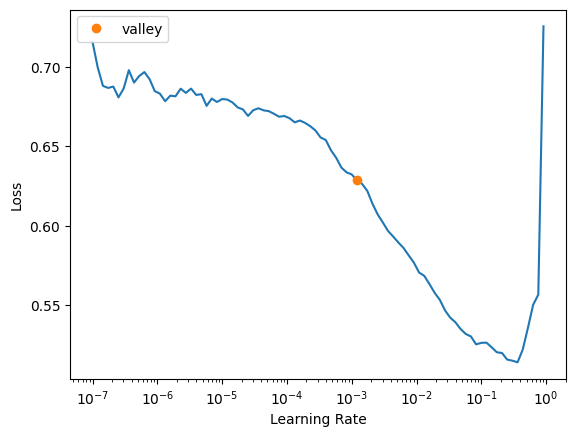

In [68]:
learn.lr_find()

In [69]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,0.470358,0.505383,0.779632,00:01
1,0.348673,0.576925,0.701381,00:01
2,0.181861,0.579886,0.718642,00:01
3,0.087664,0.651712,0.702532,00:01
4,0.053397,0.614518,0.752014,00:01
5,0.053329,0.635327,0.764672,00:01
6,0.059427,0.704964,0.757192,00:01
7,0.069764,0.661937,0.769850,00:01
8,0.054571,0.700402,0.785961,00:01
9,0.055928,0.714944,0.780207,00:01


No improvement since epoch 8: early stopping


In [64]:
learn.show_results()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Transported_pred
0,2.0,1.0,2062.0,3.0,1.0,275.0,1.0,1.0,1.0,1.0,1.0,1.0,2.581973,0.217484,1.409345,-0.305568,0.774041,-0.268227,0.0,0.0
1,3.0,1.0,1074.0,3.0,1.0,8366.0,1.0,1.0,1.0,1.0,1.0,1.0,0.560276,1.677395,-0.288000,-0.303705,-0.175086,0.089808,0.0,0.0
2,2.0,1.0,944.0,3.0,1.0,822.0,1.0,1.0,1.0,1.0,1.0,1.0,0.002566,-0.340624,0.436861,-0.305568,1.384004,0.670737,0.0,1.0
3,2.0,0.0,1250.0,3.0,1.0,2620.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.485430,-0.340624,2.102047,-0.305568,0.701236,1.543887,0.0,1.0
4,1.0,2.0,5654.0,3.0,1.0,2844.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.973426,-0.340624,-0.288000,-0.305568,-0.273639,-0.268227,1.0,1.0
5,1.0,2.0,6049.0,2.0,1.0,4843.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.740276,-0.340624,-0.288000,-0.305568,-0.273639,-0.268227,1.0,1.0
6,1.0,2.0,5820.0,3.0,1.0,7393.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.067148,-0.340624,-0.288000,-0.305568,-0.273639,-0.268227,0.0,1.0
7,1.0,1.0,5214.0,2.0,1.0,3986.0,1.0,1.0,1.0,1.0,1.0,1.0,3.069968,2.506675,-0.288000,-0.217994,-0.273639,-0.268227,0.0,0.0
8,2.0,2.0,222.0,1.0,1.0,7507.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.415716,-0.340624,-0.288000,-0.305568,-0.273639,-0.268227,1.0,1.0
